# Implementing CRISP-DM Methodology

<img src='https://imgs.search.brave.com/xJ5euW0KJqvoedGH2o3aL7vKBx-qDSN5659B5iCA5Ds/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy9i/L2I5L0NSSVNQLURN/X1Byb2Nlc3NfRGlh/Z3JhbS5wbmc'
height = '40%' width = '40%'>


# Note: Importing Datasets from kaggle

In [10]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !kaggle datasets download -d chetankv/dogs-cats-images

# Importing Datasets from Google Drive link

gdown library is specifically designed to download files from Google Drive links only

In [11]:
import gdown

original_url = 'https://drive.google.com/file/d/1xc5RqBg6OXu09JPc97gfsDT_LmpAMWkP/view?usp=drive_link'

# Converting into a download path
id = "1xc5RqBg6OXu09JPc97gfsDT_LmpAMWkP"
url = f'https://drive.google.com/uc?id={id}'
gdown.download(url, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1xc5RqBg6OXu09JPc97gfsDT_LmpAMWkP
To: /content/classification: crow_vs_sparrow.zip
100%|██████████| 7.50M/7.50M [00:00<00:00, 67.8MB/s]


'classification: crow_vs_sparrow.zip'

## Extracting datasets

In [12]:
import zipfile
zip_ref = zipfile.ZipFile('classification: crow_vs_sparrow.zip','r')
zip_ref.extractall()
zip_ref.close()

# Importing Library

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from sklearn.metrics import classification_report, precision_score, recall_score

%matplotlib inline


# Goal | Business Understanding

- To develop a Deep Learning model to automatically classify images of birds as either crow or sparrow?

# Success Criteria | Business Understanding

- accuracy > 90%,
- val_accuracy > 90%,
- precision > 90%,
- recall > 90%.

# Data Sources and Collection | Business Understanding

- Source: Drive
- Collection: https://drive.google.com/file/d/1xc5RqBg6OXu09JPc97gfsDT_LmpAMWkP/view?usp=drive_link


# Exploratory Image Analysis | Data Understanding

Visualization:

(-0.5, 223.5, 223.5, -0.5)

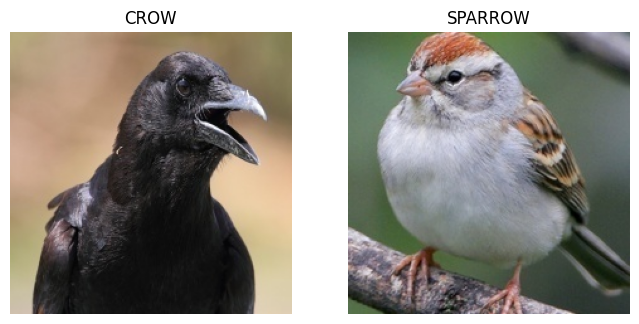

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

img_crow = load_img('classification: crow_vs_sparrow/Test/CROW/1.jpg')
img_sparrow = load_img('classification: crow_vs_sparrow/Test/SPARROW/1.jpg')

ax[0].imshow(img_crow)
ax[0].set_title('CROW')
ax[0].axis('off')

# Plot data on the second subplot
ax[1].imshow(img_sparrow)
ax[1].set_title('SPARROW')
ax[1].axis('off')

Data Distribution:

While training a Deep Learning Model, datasets should always be equal to eachother i.e no imbalance in data

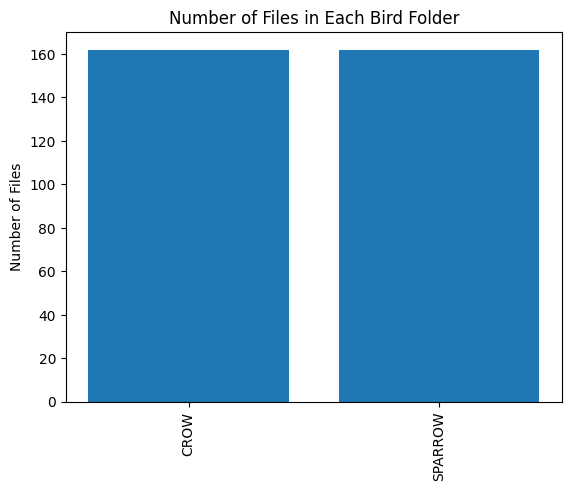

In [15]:
root_folder = 'classification: crow_vs_sparrow/Train'
subdirectories = os.listdir(root_folder)
nspecies = [len(os.listdir(os.path.join(root_folder, str(file)))) for file in sorted(subdirectories)]

plt.bar(['CROW','SPARROW'],nspecies)
plt.xticks(rotation='vertical')
plt.ylabel("Number of Files")
plt.title("Number of Files in Each Bird Folder")
plt.show()



# Image Properties

In [16]:
img_width=256
img_height=256
img_size=(img_width,img_height)
img_channels=3




# Note: Without applying Data Augmentation

In [17]:
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     directory = "classification: crow_vs_sparrow/Train",
#     labels = "inferred",
#     label_mode = 'int',
#     batch_size = 32,
#     image_size = (256,256)
# )

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     directory = "classification: crow_vs_sparrow/Test",
#     labels = "inferred",
#     label_mode = 'int',
#     batch_size = 32,
#     image_size = (256,256)
# )

# def Normalize_0_1(image,label):
#     image = tf.cast(image/255.,tf.float32)
#     return image,label

# train_dataset = train_dataset.map(Normalize_0_1)
# validation_dataset = validation_dataset.map(Normalize_0_1)

# Applying Data Augmentation | Data Preparation

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    rotation_range = 15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'classification: crow_vs_sparrow/Train',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    'classification: crow_vs_sparrow/Test',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    seed = 123,
    shuffle=False
)

Found 324 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [19]:
train_generator.class_indices

{'CROW': 0, 'SPARROW': 1}

In [20]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Defining Model | Modelling

In [21]:
model = Sequential([
    Conv2D(32,kernel_size = (3,3),padding = "valid",activation = "relu", input_shape =(img_width,img_height,img_channels)),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),

    Conv2D(64,kernel_size = (3,3),padding = "valid",activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),

    Conv2D(128,kernel_size = (3,3),padding = "valid",activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),
    Flatten(),

    Dense(128,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(1,activation = "sigmoid"),
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [23]:
optimizer = Adam(learning_rate = 0.005)

model.compile(optimizer= optimizer,loss="binary_crossentropy",metrics=['accuracy'])

In [24]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

In [25]:
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 2,
    verbose = 1,
    min_lr = 1e-6
)

In [26]:
mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [27]:
callbacks = [early_stopping,lr_scheduler,mc]

In [28]:
epochs=50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 54.3899 - accuracy: 0.4198

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 14s 506ms/step - loss: 54.3899 - accuracy: 0.4198 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/50
11/11 [==============================] - 5s 436ms/step - loss: 0.7038 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/50
11/11 [==============================] - 6s 527ms/step - loss: 0.6969 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.5000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
11/11 [==============================] - 6s 510ms/step - loss: 0.6991 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 5/50
11/11 [==============================] - 5s 439ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5000 - lr: 1.0000e-03
Epoch 6/50
11/11 [==============================] - 6s 521ms/step - los

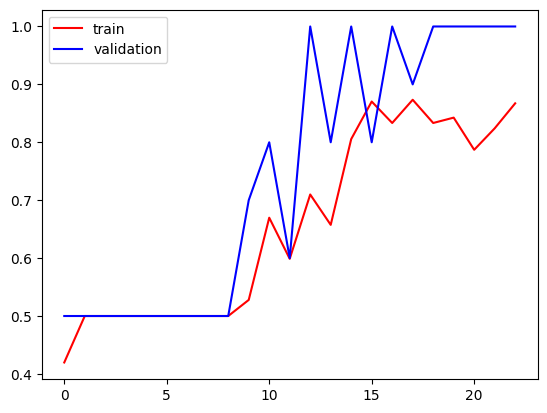

In [29]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color = 'blue',label='validation')
plt.legend()
plt.show()

# Testing | Evaluation

In [38]:
# Generate predictions on the test set
y_pred_probs = model.predict(validation_generator)
print(y_pred_probs)

1/1 [==============================] - 0s 64ms/step
[[0.440832  ]
 [0.49406064]
 [0.49719876]
 [0.45979255]
 [0.43796527]
 [0.60974884]
 [0.57364863]
 [0.603819  ]
 [0.6108054 ]
 [0.572673  ]]


In [39]:
# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

#reshaping into one dimensional value
print(y_pred_binary)


[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [40]:
# True Values
y_actual = validation_generator.classes
print(y_actual)

[0 0 0 0 0 1 1 1 1 1]


In [41]:
precision = precision_score(y_actual, y_pred_binary)
recall = recall_score(y_actual, y_pred_binary)

print(f"Precision:{precision} and Recall: {recall}")

Precision:1.0 and Recall: 1.0


In [42]:
# Generate classification report
print(classification_report(y_actual, y_pred_binary))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## Validating on New Data | Evaluation

In [47]:
def img_preprocess(img_path):
  img = load_img(img_path, target_size=(img_width, img_height))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.  # Normalize pixel values
  return img_array


In [64]:
img_array = img_preprocess('/content/classification: crow_vs_sparrow/Train/CROW/003.jpg')

predicted = model.predict(img_array)
print(f"{'Sparrow' if predicted>0.5 else 'Crow'}")

1/1 [==============================] - 0s 19ms/step
Crow


1/1 [==============================] - 0s 26ms/step


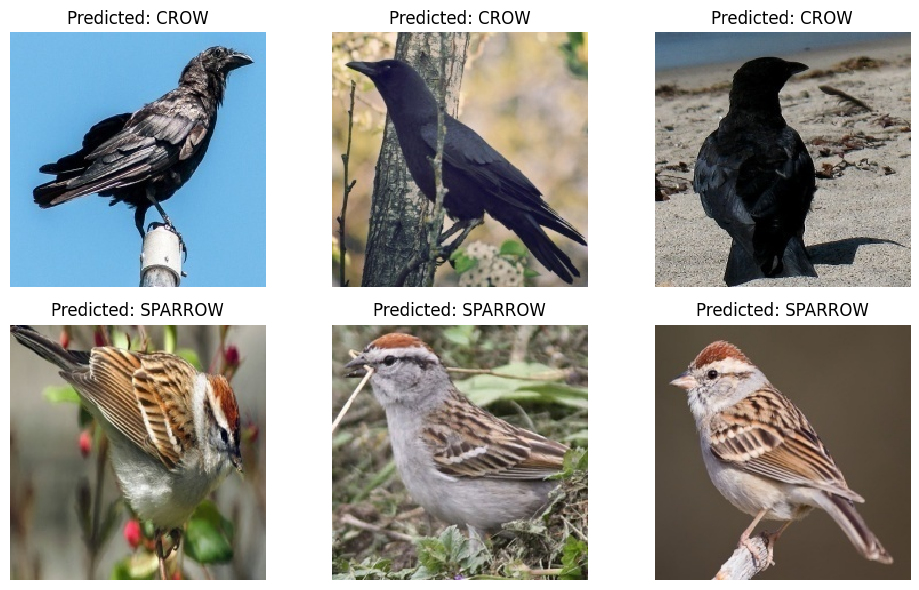

In [72]:
file_path = [
    '/content/classification: crow_vs_sparrow/Train/CROW/004.jpg',
    '/content/classification: crow_vs_sparrow/Train/CROW/012.jpg',
    '/content/classification: crow_vs_sparrow/Train/CROW/025.jpg',
    '/content/classification: crow_vs_sparrow/Train/SPARROW/005.jpg',
    '/content/classification: crow_vs_sparrow/Train/SPARROW/023.jpg',
    '/content/classification: crow_vs_sparrow/Train/SPARROW/100.jpg'
]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
ax = ax.flatten()

for i, path in enumerate(file_path):
    # Direct Solution: img = load_img(path)
    img_array = img_preprocess(path)
    ax[i].imshow(img_array[0])

    # Remove axis ticks and labels
    ax[i].axis('off')

    #make prediction and show the results
    pred = model.predict(img_array)
    pred_class = "CROW" if pred < 0.5 else "SPARROW"
    # confidence = pred if pred < 0.5 else 1 - pred
    ax[i].set_title(f'Predicted: {pred_class}')


# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show the subplots
plt.show()